In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tkinter import Tk
from tkinter.filedialog import askdirectory

# Defining the JM colours
JM_colours = {'dark blue':(30/235,34/235,170/235), 'light blue':(0,172/235,233/235), 'teal':(157/235,211/235,203/235), 'pink':(229/235,0,118/235), 'grey':(87/235,87/235,86/235)}

## Import the folder with .mpt files from EC Lab

In [2]:
#Open a Tkinter window to select the folder interactively
Tk().withdraw()
folder_path = askdirectory(title='Select Folder')

#Get user input for electrode area in cm²
electrode_area_cm2 = float(input("Enter the electrode area (cm²): "))

data_list = []

for file in os.listdir(folder_path):
    if file.endswith(".mpt"):
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
            
            #Extract the column names from the header line
            header_line = lines[58].strip().split('\t')
            
            #Extract the data section
            data_start = 59
            data_lines = [line.strip().split('\t') for line in lines[data_start:]]
            
            #Create a dataframe for the data
            df_data = pd.DataFrame(data_lines, columns=header_line)
            
            #Create a dictionary or list of values for each file
            data = {
                'File': file,
                'Data': df_data
            }
            
            data_list.append(data)

df = pd.DataFrame(data_list)
#Accessing the data from the first .mpt file
first_file_data = df.loc[0, 'Data']

## Extract the relevant columns and clean the dataset

In [3]:
# Create an empty dataframe to store the extracted values
result_df = pd.DataFrame(columns=['File', 'Ewe/V', '<I>/mA'])

# Iterate over each dataframe in df
for i, row in df.iterrows():
    file_data = row['Data']
    file_name = row['File']
    
    # Accessing specific columns from each dataframe
    ewe_values = file_data['Ewe/V']
    current_values = file_data['<I>/mA']
    cycle_number = file_data['cycle number']
    
    # Create a temporary dataframe with the extracted values
    temp_df = pd.DataFrame({
        'File': [file_name] * len(ewe_values),
        'Ewe/V': ewe_values,
        '<I>/mA': current_values,
        'Cycle number': cycle_number
    })
    
    # Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

result_df['<I>/mA'] = result_df['<I>/mA'].astype(float) / electrode_area_cm2
result_df = result_df.rename(columns={'<I>/mA': '<I>/mAcm-2'})
result_df['Ewe/V'] = result_df['Ewe/V'].astype(float).round(2)

# Convert the cycle number column to float
result_df['Cycle number'] = result_df['Cycle number'].astype(float)

# Define a dictionary to map the current cycle numbers to the desired values
cycle_mapping = {1.0: 1, 2.0: 2, 3.0: 3}

# Replace the cycle numbers in the 'Cycle number' column
result_df['Cycle number'] = result_df['Cycle number'].replace(cycle_mapping)

# Print the updated dataframe
result_df.head()

,File,Ewe/V,<I>/mAcm-2,Cycle number
0,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.015240,1.0
1,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.034829,1.0
2,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.043969,1.0
3,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.07,0.049075,1.0
4,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.07,0.052276,1.0


In [4]:
unique_files = result_df['File'].unique()
for file in unique_files:
    print(file)

S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt
S20_CV_2_elect_Dark_200rpm_1MKOH_3_C02.mpt
S20_CV_2_elect_Light_200rpm_1MKOH_2_C02.mpt
S20_CV_3_elect_Dark_200rpm_1MKOH_2_C02.mpt
S20_CV_3_elect_Dark_200rpm_Water_2_C02.mpt
S20_CV_3_elect_Dark_200rpm_Water_C02.mpt
S20_CV_3_elect_Light_200rpm_Water_C02.mpt


## Dataset evaluation and Graph builder

In [5]:
# Create an empty dictionary to store the dataframes
dataframes = {}

# Iterate over the unique filenames
for i, file in enumerate(unique_files):
    # Filter the result_df based on the current filename
    filtered_df = result_df[result_df['File'] == file].copy()
    
    # Assign the filtered dataframe to a variable with a dynamic name
    var_name = f"df{i+1}"
    dataframes[var_name] = filtered_df

# Example: Accessing a specific dataframe
df1 = dataframes['df1']
df1.head()

,File,Ewe/V,<I>/mAcm-2,Cycle number
0,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.015240,1.0
1,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.034829,1.0
2,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.08,0.043969,1.0
3,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.07,0.049075,1.0
4,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,-0.07,0.052276,1.0


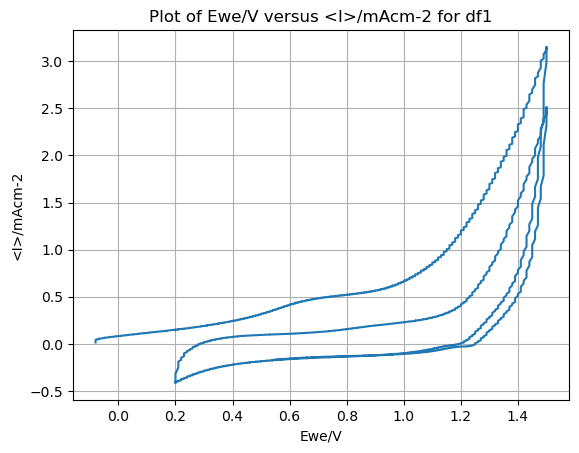

In [6]:
# Plotting Ewe/V versus <I>/mAcm-2
plt.plot(df1['Ewe/V'], df1['<I>/mAcm-2'])
plt.xlabel('Ewe/V')
plt.ylabel('<I>/mAcm-2')
plt.title('Plot of Ewe/V versus <I>/mAcm-2 for df1')
plt.grid(True)
plt.show()

## Filtered Dataset

In [7]:
def apply_filters(df):
    # Get the last cycle number
    #last_cycle_number = df['Cycle number'].max()
    # Set the mask for Cycle number
    mask1 = df['Cycle number'] == 2
    # Set the mask for 'Ewe' values within the range of 0.2 to 1.6
    mask2 = (df['Ewe/V'] >= 0.2) & (df['Ewe/V'] <= 1.6)
    # Apply the masks to filter the rows
    filtered_df = df[mask1 & mask2]
    
    return filtered_df

# Apply the filters to df1
filtered_df1 = apply_filters(df1)

# Print the filtered DataFrame
filtered_df1.head()

,File,Ewe/V,<I>/mAcm-2,Cycle number
400,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,1.50,2.991569,2.0
401,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,1.49,2.762646,2.0
402,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,1.49,2.567235,2.0
403,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,1.49,2.380046,2.0
404,S20_CV_2_elect_Dark_200rpm_1MKOH_2_C02.mpt,1.48,2.249397,2.0


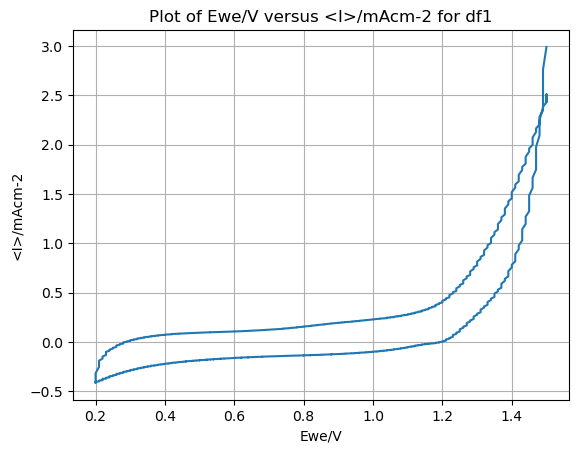

In [8]:
# Plotting Ewe/V versus <I>/mAcm-2
plt.plot(filtered_df1['Ewe/V'], filtered_df1['<I>/mAcm-2'])
plt.xlabel('Ewe/V')
plt.ylabel('<I>/mAcm-2')
plt.title('Plot of Ewe/V versus <I>/mAcm-2 for df1')
plt.grid(True)
plt.show()